In [28]:
import pandas as pd
import numpy as np
import glob
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates
import scipy.stats as stats
import statsmodels.api as sm

In [11]:
ac_trans = xr.open_dataset('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/ac_gyre_trans_2023.nc')
# Antilles Current dataset
ac_dates=ac_trans['ac_dates']
ac_series=ac_trans['integrated_ac_trans_corrected']
# Create a new DataArray
ac_series_da = xr.DataArray(ac_series.values, coords=[ac_dates], dims=["time"])
# Convert AC daily data to monthly
ac_monthly_series = ac_series_da.resample(time='M').mean()
new_time = ac_monthly_series['time'].to_index() + pd.DateOffset(days=14)
ac_monthly_series['time'] = new_time

In [12]:
fc_trans = xr.open_dataset('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/fc_transports.nc')
fc_dates = fc_trans['fc_dates']
fc_series = fc_trans['integrated_fc_trans_corrected']

# Convert fc_dates to pandas DatetimeIndex
fc_data = pd.to_datetime(fc_dates)
print(fc_dates)

# Adjust dates
def adjust(date):
    if date.day < 14:
        return date.replace(day=14)
    else:
        return date + pd.DateOffset(months=1, days=-date.day + 14)

fc_data_14th = fc_data.to_series().apply(adjust)
fc_monthly_series = xr.DataArray(data=fc_series, coords=[pd.to_datetime(fc_data_14th)], dims=["time"])


<xarray.DataArray 'fc_dates' (fc_dates: 501)>
array(['1982-04-26T00:00:00.000000000', '1982-05-27T00:00:00.000000000',
       '1982-06-26T00:00:00.000000000', ..., '2023-10-27T00:00:00.000000000',
       '2023-11-26T00:00:00.000000000', '2023-12-27T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * fc_dates  (fc_dates) datetime64[ns] 1982-04-26 1982-05-27 ... 2023-12-27


In [13]:
# Apply 3-month boxcar filter
ac_3m = ac_monthly_series.rolling(time=3, center=True).mean()/1e6
fc_3m = fc_monthly_series.rolling(time=3, center=True).mean()
# Apply 1-year boxcar filter
ac_1y = ac_3m.rolling(time=12, center=True).mean()
fc_1y = fc_3m.rolling(time=12, center=True).mean()

# Crop FC data to match the time period of AC data
# Get the indices of the first and last valid (non-NaN) entries for the AC time series
first_valid_index = ac_1y.time[~ac_1y.isnull()].min()
last_valid_index = ac_1y.time[~ac_1y.isnull()].max()

# Define the new time range
#start_date = '2016-01-01'
#end_date = '2008-12-31'

# Crop both time series to the time range 2009-2015
fc_monthly_series_cropped = fc_1y.sel(time=slice(first_valid_index, last_valid_index))
ac_monthly_series_cropped = ac_1y.sel(time=slice(first_valid_index, last_valid_index))


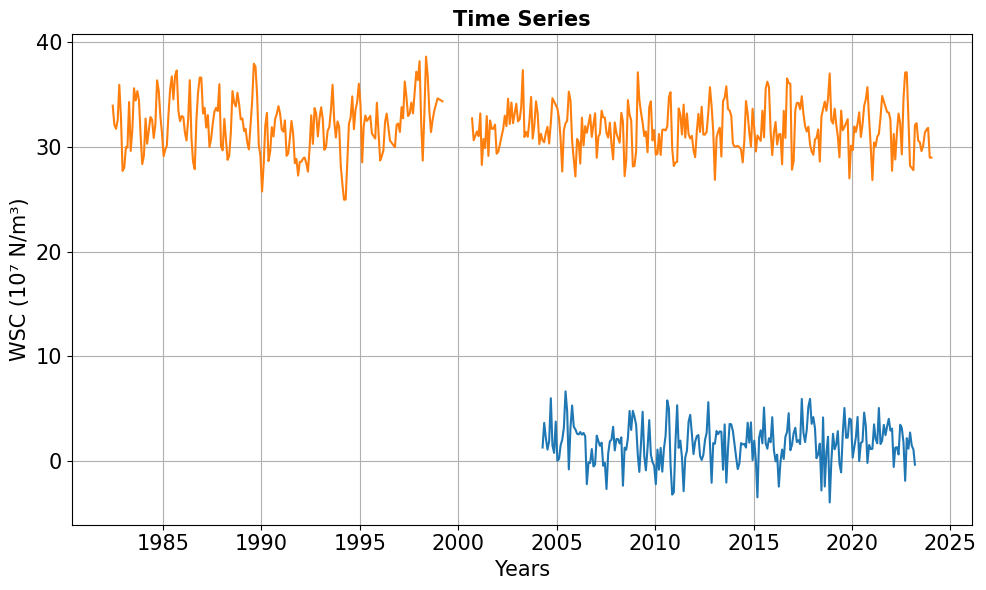

In [14]:
# Plotting the time series
plt.figure(figsize=(10, 6))
#plt.plot(ac_dates, ac_series/1e6, color='C4', linewidth=2, label='AC')
#plt.plot(fc_dates, fc_series, color='C5', linewidth=2, label='FC')
plt.plot(ac_monthly_series['time'], ac_monthly_series/1e6, color='C0', linewidth=1.5, label='AC Monthly')
plt.plot(fc_monthly_series['time'], fc_monthly_series, color='C1', linewidth=1.5, label='FC Monthly')

plt.xlabel('Years', fontsize=15)
plt.ylabel('WSC (10⁷ N/m³)', fontsize=15)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Time Series', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# Load the .mat file
data = loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/forCristina_202409/data/interim_data/floridacurrent_198204.202012.mat')

# Extract variables
fc_time = data['fcmonthly']['time'][0, 0]
fc_trans = data['fcmonthly']['trans'][0, 0]

# Flatten arrays if they have more than one dimension
if fc_time.ndim > 1:
    fc_time = np.ravel(fc_time)
if fc_trans.ndim > 1:
    fc_trans = np.ravel(fc_trans)

# Convert numeric time to datetime
# Assuming fc_time is in months since January 1982
start_date = pd.Timestamp('1982-05-01')

# Convert months to datetime
try:
    fc_dates = [start_date + pd.DateOffset(months=int(month)) for month in fc_time]
except ValueError as e:
    fc_dates = pd.date_range(start=start_date, periods=len(fc_time), freq='M')

# Add 15 days to each date in fc_dates
fc_dates_new = [date + pd.DateOffset(days=14) for date in fc_dates]

# Now fc_dates_new contains the adjusted dates with 15 days added


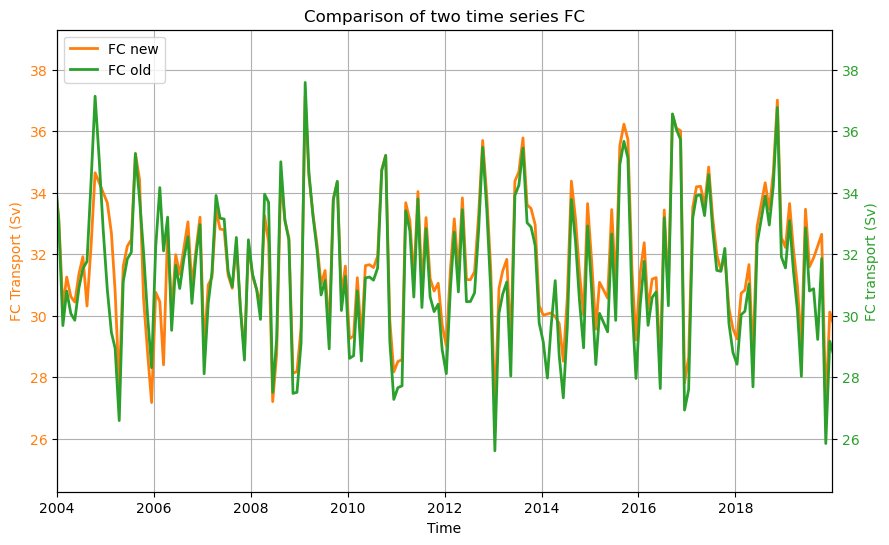

In [16]:
# Create the figure and the primary axis
fig, ax = plt.subplots(figsize=(10, 6))

# y-axis left side
ax.plot(fc_monthly_series['time'], fc_monthly_series, color='C1', linewidth=2, label='FC new')
ax.set_ylabel('FC Transport (Sv)', color='C1')
ax.tick_params(axis='y', labelcolor='C1')       

# y-axis right side
ax2 = ax.twinx()
ax2.plot(fc_dates_new, fc_trans, color='C2', linewidth=2, label='FC old')
ax2.set_ylabel('FC transport (Sv)', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

ax.set_title('Comparison of two time series FC')
ax.set_xlabel('Time')
ax.set_xlim([pd.Timestamp('2004-01-01'), pd.Timestamp('2019-12-31')])
ax.grid(True)

# Combine legends
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

#print(fc_dates_new)
#print(fc_monthly_series['time'])

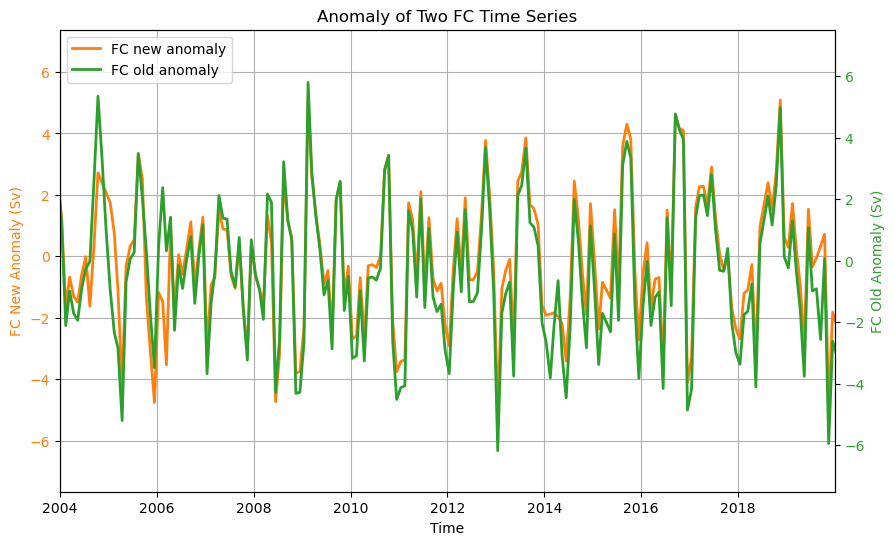

In [30]:
# Compute the mean of each time series
fc_new_mean = fc_monthly_series.mean()# Mean of the new FC time series
fc_old_mean = np.mean(fc_trans)# Mean of the old FC time series

# Calculate the anomalies
fc_new_anomaly = fc_monthly_series - fc_new_mean# Anomaly for the new FC time series
fc_old_anomaly = fc_trans - fc_old_mean# Anomaly for the old FC time series

fig, ax = plt.subplots(figsize=(10, 6))
# y-axis left side: New FC
ax.plot(fc_monthly_series['time'], fc_new_anomaly, color='C1', linewidth=2, label='FC new anomaly')
ax.set_ylabel('FC New Anomaly (Sv)', color='C1')
ax.tick_params(axis='y', labelcolor='C1')

# y-axis right side: Old FC
ax2 = ax.twinx()
ax2.plot(fc_dates_new, fc_old_anomaly, color='C2', linewidth=2, label='FC old anomaly')
ax2.set_ylabel('FC Old Anomaly (Sv)', color='C2')
ax2.tick_params(axis='y', labelcolor='C2')

ax.set_title('Anomaly of Two FC Time Series')
ax.set_xlabel('Time')
ax.grid(True)

ax.set_xlim([pd.Timestamp('2004-01-01'), pd.Timestamp('2019-12-31')])

#Legend
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

#print(fc_dates_new)
#print(fc_monthly_series['time'])


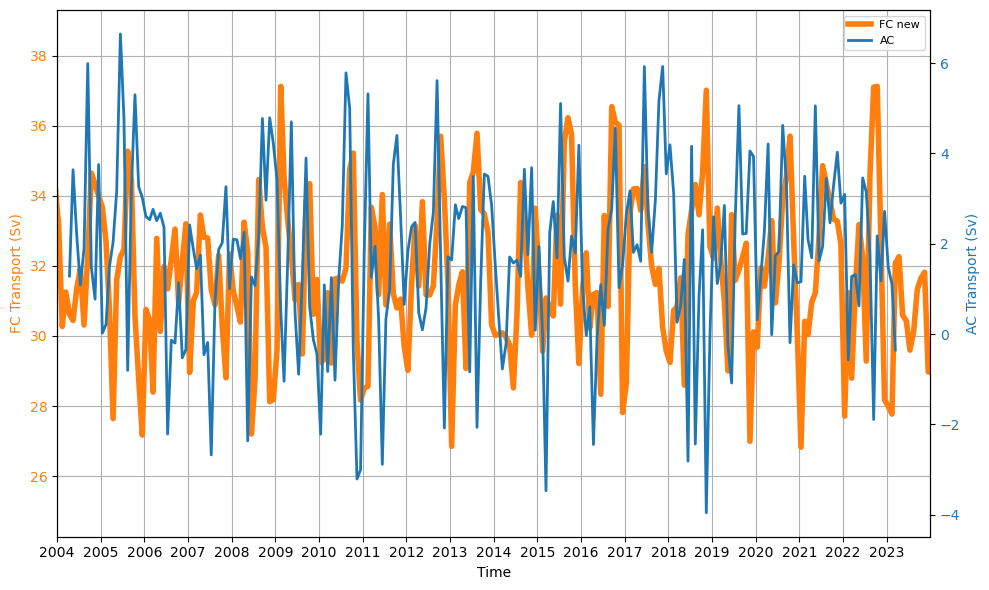

In [17]:
# Function to create a dual y-axis plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot FC data on the primary y-axis (left side)
ax.plot(fc_monthly_series['time'], fc_monthly_series, color='C1', linewidth=4, label='FC new')
ax.set_ylabel('FC Transport (Sv)', color='C1')  # Set the label for the left y-axis
ax.tick_params(axis='y', labelcolor='C1')       # Set the tick color to match the line color
#ax.plot(fc_dates_new, fc_trans, color='C2', linewidth=2, label='FC old')

# Create a secondary y-axis for the AC data (right side)
ax2 = ax.twinx()
ax2.plot(ac_monthly_series['time'], ac_monthly_series/1e6, color='C0', linewidth=2, label='AC')
ax2.set_ylabel('AC Transport (Sv)', color='C0')  # Set the label for the right y-axis
ax2.tick_params(axis='y', labelcolor='C0')               # Set the tick color to match the line color
ax.grid(True)

# If time data is in datetime format, set x-axis limits using actual dates
ax.set_xlim([pd.Timestamp('2004-01-01'), pd.Timestamp('2023-12-31')])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display year only
ax.xaxis.set_major_locator(mdates.YearLocator(1))         # Tick every year

# Combine legends from both y-axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)

# Set the x-axis label
ax.set_xlabel('Time')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


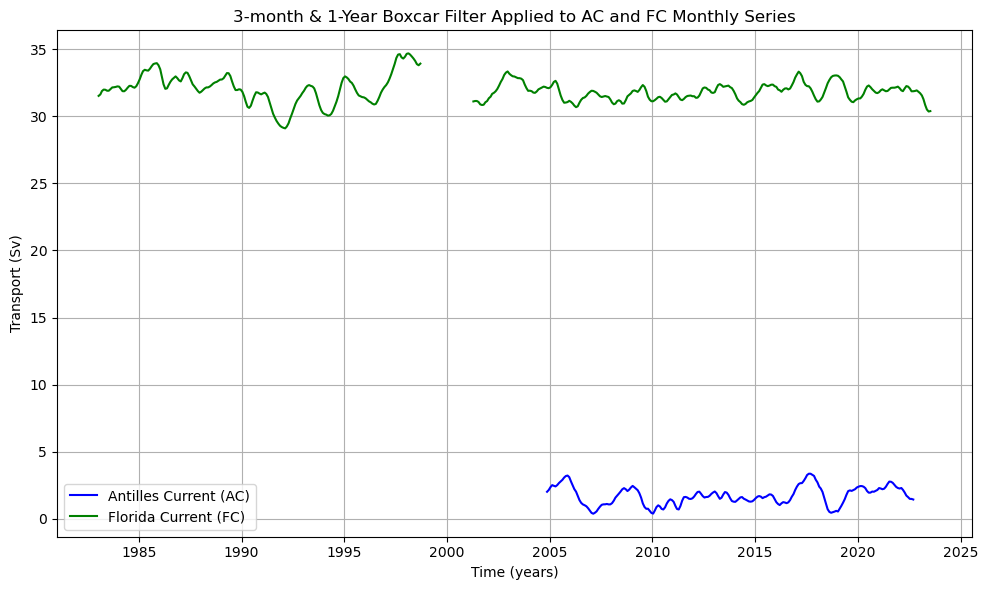

In [18]:
# Plotting the filtered series
plt.figure(figsize=(10, 6))
plt.plot(ac_1y.time, ac_1y, label="Antilles Current (AC)", color='blue')
plt.plot(fc_1y.time, fc_1y, label="Florida Current (FC)", color='green')
plt.title("3-month & 1-Year Boxcar Filter Applied to AC and FC Monthly Series")
plt.xlabel("Time (years)")
plt.ylabel("Transport (Sv)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#print(ac_1y)
#print(fc_1y)


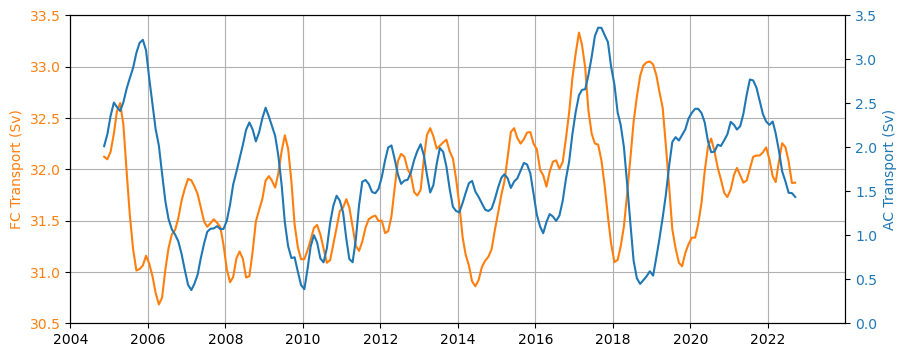

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
# y-axis for the FC data (right side)
ax.plot(fc_monthly_series_cropped.time, fc_monthly_series_cropped, label="Florida Current (FC)", color='C1')
ax.set_ylabel('FC Transport (Sv)', color='C1')
ax.tick_params(axis='y', labelcolor='C1')
ax.set_xlim([pd.Timestamp('2004-01-01'), pd.Timestamp('2023-12-31')])
ax.set_ylim([30.5,33.5])

# y-axis for AC data (left side)
ax2 = ax.twinx()
ax2.plot(ac_monthly_series_cropped.time, ac_monthly_series_cropped, label="Antilles Current (AC)", color='C0')
ax2.set_ylabel('AC Transport (Sv)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax2.set_ylim([0,3.5])

ax.grid(True)

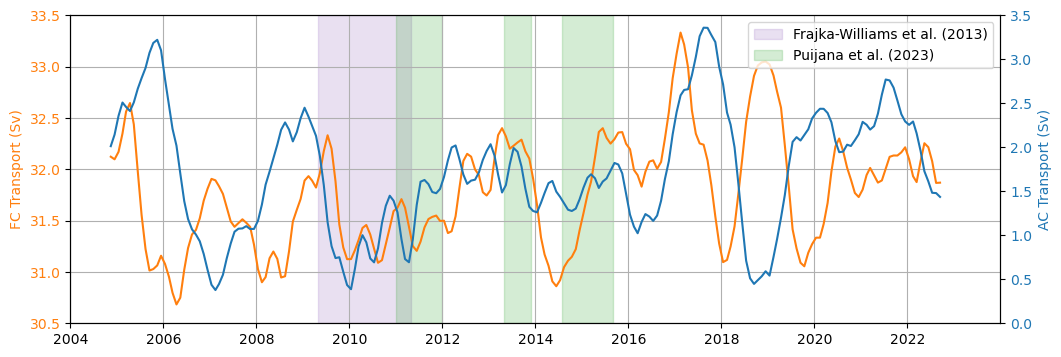

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))

# highlighted periods
highlight_periods = [('2011-01-01','2011-12-31'),('2013-05-01','2013-11-30'),('2014-08-01','2015-08-31')]
frajkawilliams_period =[('2009-05-01','2011-04-30')]

# Highlight the Frajka-william periods of strong eddie activity in purple 
for start, end in frajkawilliams_period:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), color='C4', alpha=0.2, label='Frajka-Williams et al. (2013)')
# Highlight Puijana et al. (2023) periods of strong eddy activity in green
for start, end in highlight_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), color='C2', alpha=0.2,label='Pujiana et al. (2023)')
plt.legend(['Frajka-Williams et al. (2013)','Puijana et al. (2023)'],loc='upper right')

# y-axis for Florida Current (left side)
ax.plot(fc_monthly_series_cropped.time, fc_monthly_series_cropped, label="Florida Current (FC)", color='C1')
ax.set_ylabel('FC Transport (Sv)', color='C1')
ax.tick_params(axis='y', labelcolor='C1')
ax.set_xlim([pd.Timestamp('2004-01-01'), pd.Timestamp('2023-12-31')])
ax.set_ylim([30.5, 33.5])

# y-axis forAntilles Current (right side)
ax2 = ax.twinx()
ax2.plot(ac_monthly_series_cropped.time, ac_monthly_series_cropped, label="Antilles Current (AC)", color='C0')
ax2.set_ylabel('AC Transport (Sv)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax2.set_ylim([0, 3.5])
ax.grid(True)
plt.show()


In [21]:
# Lag correlation function using xarray
def lag_correlation(data1, data2, max_lag):
    correlations = []
    len_ser = []
    len_data1 = len(data1)
    len_data2 = len(data2)

    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            # For negative lag: shift data2 forward, reducing the effective length of data2
            shifted_data2 = data2.shift(time=-lag)
            corr = xr.corr(data1, shifted_data2, dim='time')
            len_overlap = min(len_data1 + lag, len_data2)  # Account for the reduced length of data1
        else:
            # For positive lag: shift data1 forward, reducing the effective length of data1
            shifted_data1 = data1.shift(time=lag)
            corr = xr.corr(shifted_data1, data2, dim='time')
            len_overlap = min(len_data1, len_data2 - lag)  # Account for the reduced length of data2

        correlations.append(corr.values)  # Extract the correlation value
        len_ser.append(len_overlap)  # Track the length of overlapping data
    
    return correlations, len_ser

max_lag = 36  # number of months to do the lag correlation
lags = range(-max_lag, max_lag + 1)
correlations_fc_ac, len_ser = lag_correlation(ac_monthly_series_cropped, fc_monthly_series_cropped, max_lag)
#print(correlations_fc_ac)
#print(len_ser)

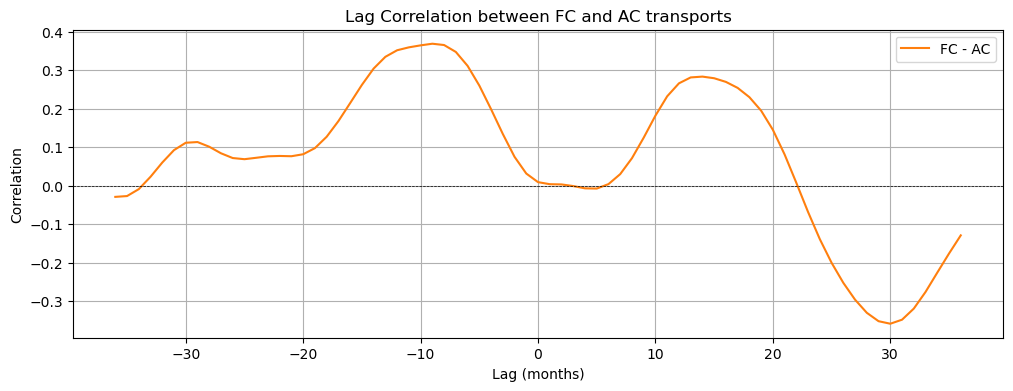

In [23]:
# Plot the lag correlations GYRE
plt.figure(figsize=(12, 4))
plt.plot(lags, correlations_fc_ac, label='FC - AC', color='C1')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.title('Lag Correlation between FC and AC transports')
plt.legend()
plt.grid()
plt.show()
#print(correlations_fc_ac)

In [24]:
# Convert lags to NumPy array
lags = np.array(lags)

# indices for lags between 0 and 36
positive_lag_indices = np.array([i for i, lag in enumerate(lags) if 0 <= lag <= max_lag])
correlations_fc_ac = np.array([corr.item() for corr in correlations_fc_ac])

filtered_correlations = correlations_fc_ac#[positive_lag_indices] #for positive lags
absolute_filtered_correlations = np.abs(filtered_correlations)

# Select the maximum absolute correlation and corresponding best lag using only positive lags
max_corr_fc_ac = np.max(absolute_filtered_correlations)
#best_lag_fc_ac = lags[positive_lag_indices[np.argmax(absolute_filtered_correlations)]]
best_lag_fc_ac = lags[np.argmax(absolute_filtered_correlations)]
# Print the actual maximum correlation and the best lag (with the original sign)
best_actual_correlation = filtered_correlations[np.argmax(absolute_filtered_correlations)]
print(f"Best lag: {best_lag_fc_ac}")
print(f"Maximum correlation (with sign): {best_actual_correlation}")

# Shift the fc_monthly_series_cropped by the best lag
shifted_ac_fc = ac_monthly_series_cropped.shift(time=best_lag_fc_ac)

#best_lag_fc_ac=lags[positive_lag_indices[np.argmax(correlations_fc_ac[positive_lag_indices])]]
#best_lag_fc_ac = lags[np.argmax(correlations_fc_ac)]
#shifted_ac_fc = fc_monthly_series_cropped.shift(time=best_lag_fc_ac)

Best lag: -9
Maximum correlation (with sign): 0.3685209267321009


In [16]:
#print(fc_monthly_series_cropped)
#print(ac_1y)

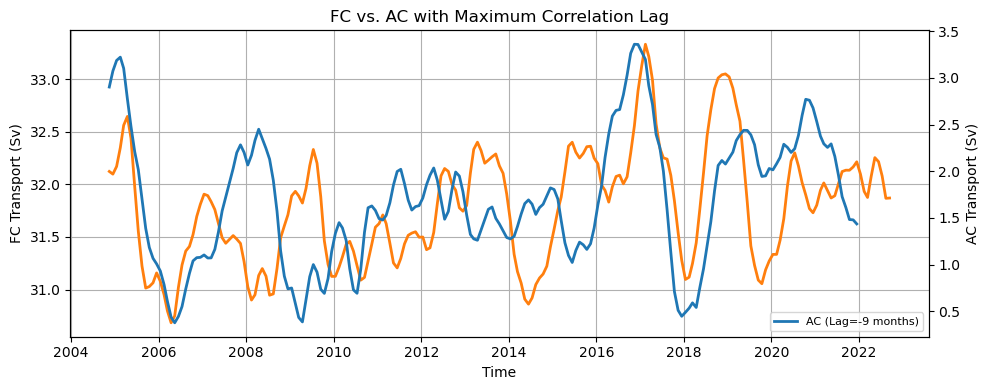

215
206
Maximum Lag Correlation (FC-AC): 0.3685209267321009 at lag -9


In [25]:
# Function to create a dual y-axis plot
def create_dual_axis_plot(ax, fc_data, ac_data, title, best_lag):
    # Plot FC data on the primary y-axis (left side)
    ax.plot(fc_monthly_series_cropped.time, fc_data, color='C1', linewidth=2, label='')
    ax.set_ylabel('FC Transport (Sv)')
    
    # Create a secondary y-axis for the AC data (right side)
    ax2 = ax.twinx()
    ax2.plot(ac_monthly_series_cropped.time, ac_data, color='C0', linewidth=2, label=f'AC (Lag={best_lag} months)')
    ax2.set_ylabel('AC Transport (Sv)')
    ax.set_title(title)
    ax.grid(True)

    # Combine legends from both y-axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=8)


fig, ax = plt.subplots(figsize=(10, 4))
create_dual_axis_plot(ax, fc_monthly_series_cropped, shifted_ac_fc, 'FC vs. AC with Maximum Correlation Lag', best_lag_fc_ac)
ax.set_xlabel('Time')
plt.tight_layout()
plt.show()

print(len(ac_monthly_series_cropped[~np.isnan(ac_monthly_series_cropped)]))
print(len(shifted_ac_fc[~np.isnan(shifted_ac_fc)]))

# Print the maximum correlation and the corresponding lag
print(f'Maximum Lag Correlation (FC-AC): {best_actual_correlation} at lag {best_lag_fc_ac}')


In [29]:
autocorr= sm.tsa.acf(fc_monthly_series_cropped,nlags=len(fc_monthly_series_cropped)-1)
T_int=1+2*np.sum(autocorr)
N_eff=len_ser/T_int
N_eff_max=len(fc_monthly_series_cropped-3)/T_int#for maximum correlation

r = correlations_fc_ac 
#r = best_actual_correlation# Maximum correlation
#n = len(fc_monthly_series_cropped)  # Number of observations

# Calculate the t-statistic
t_statistic = r * np.sqrt(N_eff - 2) / np.sqrt(1 - r**2)
#t_statistic_auto=r * np.sqrt(autocorr - 2) / np.sqrt(1 - r**2)
# Calculate the p-value (two-tailed)
p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df=N_eff - 2))

p_value2 = 2 * (1 - stats.t.cdf(np.abs(t_statistic2), df=N_eff2 - 2))

# Fisher's Z transformation
z = 0.5 * np.log((1 + r) / (1 - r))
se = 1 / np.sqrt(N_eff - 3) #standard error

# Calculate the confidence interval
z_critical = stats.norm.ppf(1 - 0.05 / 2)  # for 95% CI is 1.96
lower_bound = z - z_critical * se
upper_bound = z + z_critical * se

# Transform back from Z to r
lower_bound_r = (np.exp(2 * lower_bound) - 1) / (np.exp(2 * lower_bound) + 1)
upper_bound_r = (np.exp(2 * upper_bound) - 1) / (np.exp(2 * upper_bound) + 1)

lower_bound_r2 = (np.exp(2 * lower_bound2) - 1) / (np.exp(2 * lower_bound2) + 1)
upper_bound_r2 = (np.exp(2 * upper_bound2) - 1) / (np.exp(2 * upper_bound2) + 1)

# Print results
#print(f'T-statistic: {t_statistic}, p-value: {p_value}')
#print(f'95% Confidence interval for the correlation: ({lower_bound_r}, {upper_bound_r})')

#plt.plot(autocorr)
#plt.hlines(0,0,160,color='red')
#plt.xlim(0,20)
#print(T_int)

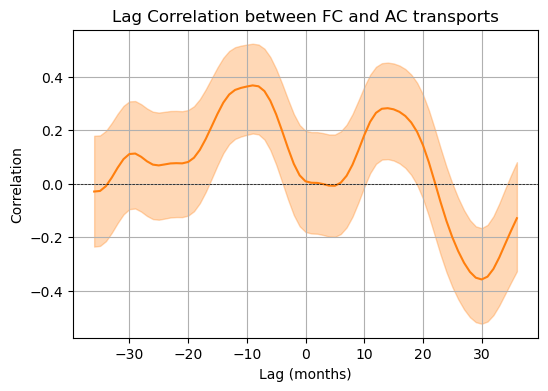

In [30]:
# Plot the lag correlations GYRE
plt.figure(figsize=(6, 4))
plt.plot(lags, correlations_fc_ac, label='FC - AC', color='C1')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.fill_between(lags,lower_bound_r,upper_bound_r,alpha=0.3,color='C1')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.title('Lag Correlation between FC and AC transports')
plt.grid()
plt.show()

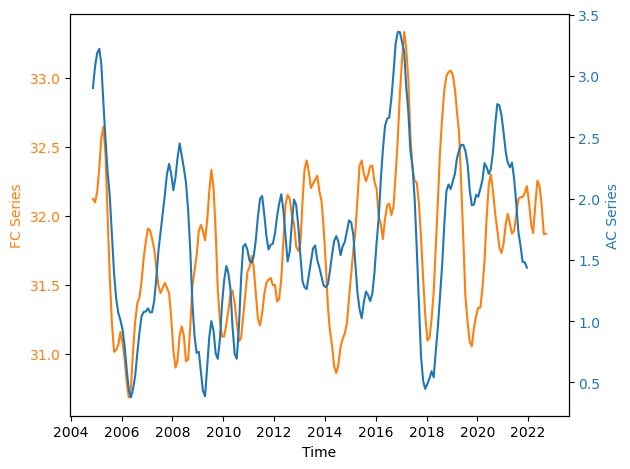

<xarray.DataArray ()>
array(0.36852093)


In [38]:
# shifted AC series
trimmed_ac_series = shifted_ac_fc.dropna(dim='time')  # Remove NaNs

# Plot the two time series
fig, ax1 = plt.subplots()
ax1.plot(fc_monthly_series_cropped.time, fc_monthly_series_cropped, color='C1', label='FC Series')
ax1.set_xlabel('Time')
ax1.set_ylabel('FC Series', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
ax2 = ax1.twinx()
ax2.plot(trimmed_fc_series.time, trimmed_ac_series, color='C0', label='AC Series')
ax2.set_ylabel('AC Series', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax.grid(True)
plt.tight_layout()
plt.show()

corr = xr.corr(fc_monthly_series_cropped,shifted_ac_fc)
print(corr)

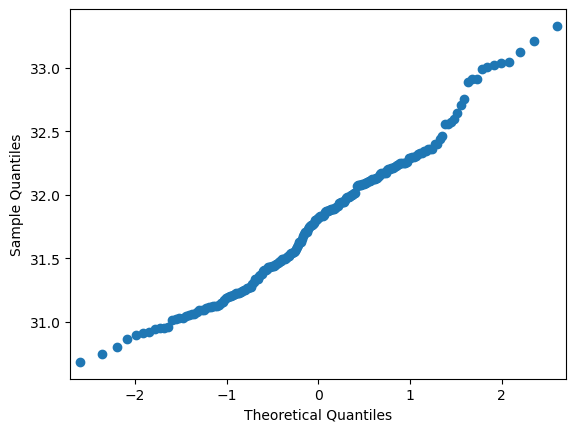

In [39]:
import statsmodels.api as sm
ppplot = sm.ProbPlot(fc_monthly_series_cropped)
fig = ppplot.qqplot()

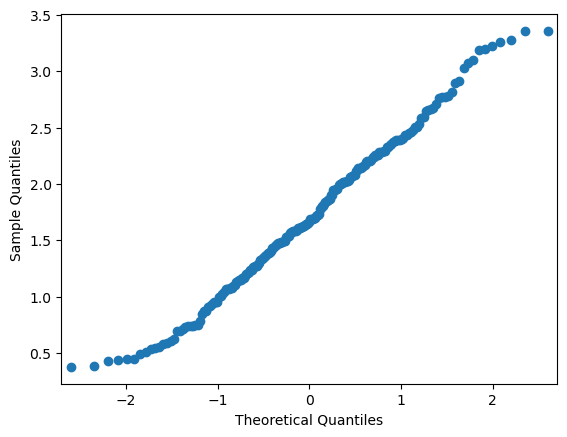

In [40]:
ppplot = sm.ProbPlot(ac_monthly_series_cropped)
fig = ppplot.qqplot()

In [41]:
from scipy.stats import pearsonr, stats, norm, probplot, jarque_bera, shapiro, kstest
print(f'jarqueb: {jarque_bera(fc_monthly_series_cropped), jarque_bera(ac_monthly_series_cropped)}') # see https://www.statology.org/jarque-bera-test-python/, p-value below 0.05 would indicate skewness
print(f'shapiro: {shapiro(fc_monthly_series_cropped), shapiro(ac_monthly_series_cropped)}') # see https://www.statology.org/shapiro-wilk-test-python/, p-value below 0.05 would indicate non-normality
#print(f'kstest: {kstest(fc_monthly_series_cropped, 'norm'), kstest(ac_monthly_series_cropped, 'norm')}') # see https://www.statology.org/kolmogorov-smirnov-test-python/ p-value below 0.05 would indicate non-normality

jarqueb: (SignificanceResult(statistic=5.222974128538904, pvalue=0.07342527443584888), SignificanceResult(statistic=3.287389235480185, pvalue=0.19326468248965975))
shapiro: (ShapiroResult(statistic=0.9766972064971924, pvalue=0.0012514358386397362), ShapiroResult(statistic=0.986726701259613, pvalue=0.04241639003157616))
